In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold 
from sklearn import svm
from sklearn.metrics import mean_squared_error

In [3]:
dataset = pd.read_csv("sgemm_product.csv")
dataset.shape

(241600, 18)

In [4]:
dataset['AverageRun'] = dataset[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis = 1)

In [5]:
dataset['AverageRun'].describe()

count    241600.000000
mean        217.571953
std         368.750161
min          13.317500
25%          40.667500
50%          69.790000
75%         228.387500
max        3341.507500
Name: AverageRun, dtype: float64

In [6]:
def scale_columns(dataframe):
    dfSubmean = dataframe - dataframe.mean()
    return dfSubmean / dataframe.std()

In [8]:
x = scale_columns(dataset[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']])
x[['STRM','STRN','SA','SB']] = dataset[['STRM','STRN','SA','SB']]
x.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,0,0
1,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,0,1
2,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,1,0
3,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,1,1
4,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,1,0,0


In [9]:
dataset['AverageRun'].median()

69.79

In [10]:
def isGreaterThanMedian(x, median):
    if x > median:
        return 1
    return 0

In [11]:
median = dataset['AverageRun'].median()
target = dataset['AverageRun'].apply(isGreaterThanMedian, args = (median,))

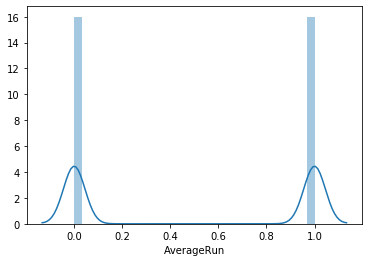

In [12]:
sns.distplot(target)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size= 0.30, random_state=123)

In [14]:
linear_svc = svm.SVC(kernel='linear')

In [15]:
y_train.shape

(169120,)

In [16]:
val_mse = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    linear_svc.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = linear_svc.predict(X_train.iloc[val_index])
    val_mse.append(mean_squared_error(y_train.iloc[val_index], y_pred))

In [17]:
print(val_mse)

[0.17008632923368022, 0.16718897824030274, 0.16358207190160834, 0.16857852412488175, 0.16727767265846735]


In [18]:
sum(val_mse)/len(val_mse)

0.16734271523178806

In [19]:
sigmoid_svc = svm.SVC(kernel='sigmoid', gamma = 'auto')
sig_val_mse = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    sigmoid_svc.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = sigmoid_svc.predict(X_train.iloc[val_index])
    sig_val_mse.append(mean_squared_error(y_train.iloc[val_index], y_pred))
sum(sig_val_mse)/len(sig_val_mse)

0.3380676442762535

In [21]:
rbf_svc = svm.SVC(kernel='rbf', gamma = 'auto')
rbf_val_mse = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    rbf_svc.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = rbf_svc.predict(X_train.iloc[val_index])
    rbf_val_mse.append(mean_squared_error(y_train.iloc[val_index], y_pred))
sum(rbf_val_mse)/len(rbf_val_mse)

0.04396286660359508

In [20]:
from sklearn.tree import DecisionTreeClassifier
depth_list=[2,6,12,18,22,None]
for i in depth_list:
    dtree = DecisionTreeClassifier(max_depth = i)
    dtree.fit(X_train,y_train)
    y_pred = dtree.predict(X_test)
    train_score = dtree.score(X_train,y_train)
    test_score = dtree.score(X_test,y_test)
    print("Max depth " + str(i) + " training score is " + train_score.astype(str) 
      + " and test score is " + test_score.astype(str))

Max depth 2 training score is 0.699296357615894 and test score is 0.6964128035320089
Max depth 6 training score is 0.8633751182592242 and test score is 0.8613272626931567
Max depth 12 training score is 0.9746807000946074 and test score is 0.9713438189845475
Max depth 18 training score is 0.9989593188268685 and test score is 0.9905491169977925
Max depth 22 training score is 1.0 and test score is 0.9909216335540839
Max depth None training score is 1.0 and test score is 0.9910596026490066


In [22]:
from sklearn.ensemble import GradientBoostingClassifier
depth_list=[2,4,8,12,None]
for i in depth_list:
    gbc = GradientBoostingClassifier(learning_rate=1, n_estimators=50,max_depth=i,random_state=None)
    gbc.fit(X_train,y_train)
    train_score = gbc.score(X_train,y_train)
    test_score = gbc.score(X_test,y_test)
    print("Max depth " + str(i) + " training score is " + train_score.astype(str) 
          + " and test score is " + test_score.astype(str))

Max depth 2 training score is 0.9238114947965941 and test score is 0.9198399558498896
Max depth 4 training score is 0.9732379375591296 and test score is 0.9711920529801324
Max depth 8 training score is 0.99860454115421 and test score is 0.9913907284768212
Max depth 12 training score is 0.9999408703878903 and test score is 0.9929773730684327
Max depth None training score is 1.0 and test score is 0.990880242825607


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
estimators_list=[10,25,50,75,100]
for i in estimators_list:
    gbc = GradientBoostingClassifier(learning_rate=1, n_estimators=i,max_depth=2,random_state=None)
    gbc.fit(X_train,y_train)
    train_score = gbc.score(X_train,y_train)
    test_score = gbc.score(X_test,y_test)
    print("Number of estimators " + str(i) + " training score is " + train_score.astype(str) 
          + " and test score is " + test_score.astype(str))

Number of estimators 10 training score is 0.8648710974456008 and test score is 0.8612582781456953
Number of estimators 25 training score is 0.9055227057710501 and test score is 0.9014486754966887
Number of estimators 50 training score is 0.9238114947965941 and test score is 0.9198399558498896
Number of estimators 75 training score is 0.9341532639545884 and test score is 0.930546357615894
Number of estimators 100 training score is 0.9412724692526017 and test score is 0.937900110375276


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
learning_list=[0.05,0.1,0.25,0.5,0.75,1]
for i in learning_list:
    gbc = GradientBoostingClassifier(learning_rate=i, n_estimators=100,max_depth=2,random_state=None)
    gbc.fit(X_train,y_train)
    train_score = gbc.score(X_train,y_train)
    test_score = gbc.score(X_test,y_test)
    print("Learning rate " + str(i) + " training score is " + train_score.astype(str) 
          + " and test score is " + test_score.astype(str))

Learning rate 0.05 training score is 0.847930463576159 and test score is 0.8429221854304636
Learning rate 0.1 training score is 0.874314096499527 and test score is 0.8685568432671081
Learning rate 0.25 training score is 0.8927270577105014 and test score is 0.8883967991169978
Learning rate 0.5 training score is 0.9239534058656576 and test score is 0.9204056291390729
Learning rate 0.75 training score is 0.935424550614948 and test score is 0.9310430463576159
Learning rate 1 training score is 0.9412724692526017 and test score is 0.937900110375276
